# Warehouse Inventory Analysis & Replenishment Simulation (Portfolio Project)

This notebook simulates daily warehouse inventory operations and demonstrates an end-to-end workflow:
- generate SKU-level demand and inventory movements
- simulate replenishment orders arriving after supplier lead time
- evaluate service performance (fill rate, stockouts, lost sales)
- build a foundation for inventory optimization (ROP, order-up-to, MOQ)

**Note:** The dataset is synthetic but designed to reflect real warehouse behavior (demand variability, lead time variability, ordering constraints).

## 1. Introduction

Inventory management is a key challenge in warehouse operations because it requires balancing:
- **high service level** (low stockouts / high fill rate)
- **low inventory costs** (avoid excess stock, reduce holding cost)

This project simulates a warehouse environment with:
- SKU master attributes (cost, MOQ, lead time range, supplier)
- daily demand variability
- replenishment orders that arrive after lead time

The analysis will focus on:
- demand and inventory patterns
- stockout and lost sales behavior
- service level proxy (fill rate)
- preparation for inventory optimization (ROP / order-up-to policies)


## 2. Build Project

This section builds a synthetic dataset that resembles **real warehouse inventory operations**.
The simulation includes:
- SKU master data (supplier, costs, lead time range, MOQ)
- daily demand generation
- inventory consumption
- replenishment orders arriving after lead time
- stockouts treated as lost sales


### 2.1 Data Generation (Synthetic Warehouse Dataset)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### 2.2 Simulation Setup

I generate 120 days of daily warehouse activity for three SKUs.

In [2]:
np.random.seed(42)

dates = pd.date_range(start="2024-01-01", periods=400)
skus = ["SKU_A", "SKU_B", "SKU_C"]

### 2.3 SKU Master Data (Static Warehouse Attributes)

In real warehouses, SKU-level parameters are stored in ERP/WMS systems.
I define a simplified SKU master dataset containing:
- category (fast/medium/slow mover)
- supplier information
- unit cost
- minimum order quantity (MOQ)
- ordering cost
- holding cost rate (annual)
- lead time range
- initial inventory

In [3]:
# SKU master data
sku_master = {
    "SKU_A":{
        "category":"Fast Movers", 
        "supplier": "supplier_1", 
        "unit_cost": 25.0, 
        "moq":75, 
        "order_cost":45, 
        "holding_cost_rate_annual":0.22, 
        "base_demand":50, 
        "lead_time_min":2, 
        "lead_time_max":6, 
        "initial_inventory":750
    },
    
    "SKU_B":{
        "category":"Medium Movers", 
        "supplier": "supplier_2", 
        "unit_cost": 75.0, 
        "moq":50, 
        "order_cost":60, 
        "holding_cost_rate_annual":0.20, 
        "base_demand":30, 
        "lead_time_min":4, 
        "lead_time_max":9, 
        "initial_inventory":500
    },
    
    "SKU_C":{
        "category":"Slow Movers", 
        "supplier": "supplier_3", 
        "unit_cost": 125.0, 
        "moq":25, 
        "order_cost":75, 
        "holding_cost_rate_annual":0.18, 
        "base_demand":15, "lead_time_min":7, 
        "lead_time_max":14, 
        "initial_inventory":250
    },
}

### 2.4 Simulation Assumptions

- Daily demand is generated using a **Poisson distribution** (typical for demand/event counts).
- Inventory decreases as demand is fulfilled.
- If demand exceeds inventory → **lost sales** occur (no backorders).
- Replenishment uses a simple policy:
  - calculate a reorder point (ROP)
  - when inventory position ≤ ROP → place an order
  - order arrives after the supplier lead time

In [4]:
# policy knobs
cover_days = 7            # order-up-to add extra ~7 days of demand above ROP (Reorder Point)
review_policy = "daily"   # daily review

rows = []

for sku in skus:
    p = sku_master[sku]
    on_hand = int(p["initial_inventory"])
    base_demand = float(p["base_demand"])
    lead_time_min = int(p["lead_time_min"])
    lead_time_max = int(p["lead_time_max"])

    # open purchase orders: list of tuples (arrival_date, qty)
    open_pos =[]

    # simple reorder policy
    avg_lead_time = (lead_time_min + lead_time_max) / 2.0
    rop = base_demand * avg_lead_time
    order_up_to = rop + cover_days * base_demand
    
    for date in dates:

        # 1) Receive inbound POs arriving today
        receipts = 0
        still_open = []
        for (arrive_date, qty) in open_pos:
            if arrive_date == date:
                receipts += qty
            else:
                still_open.append((arrive_date, qty))

        open_pos = still_open
        on_hand += receipts
            
        # 2) Generate demand (baseline + mild seasonality + randomness)
        seasonal_factor = 1.0 + 0.15 * np.sin(2 * np.pi * (date.dayofyear /30.0))
        lam = max(base_demand * seasonal_factor, 0.1)
        demand = np.random.poisson(lam=lam)

        # 3) Fulfill demand (lost sales, no backorders)
        filled_demand = min(on_hand, demand)
        lost_sales = demand - filled_demand
        on_hand -= filled_demand
        stockout = 1 if lost_sales > 0 else 0

        # inventory position (on hand + on order)
        on_order = 0
        for (arrive_date, qty) in open_pos:  # Changed variable name to avoid conflict
            on_order += qty
        #on_order = int(sum(q for (_, q) in open_pos))

        inventory_position = int(on_hand + on_order)

        # 5) Place replenishment order if needed (ROP / Order-up-to)
        order_qty = 0
        lead_time_days = int(np.random.randint(lead_time_min, lead_time_max + 1))
        if inventory_position <= rop:
            target_qty = int(np.ceil(order_up_to - inventory_position))
            order_qty = max(int(p["moq"]), target_qty)
    
            arrival_date = date + pd.Timedelta(days=lead_time_days)
            open_pos.append((arrival_date, order_qty))

            # update inventory position after ordering (for reporting)
            on_order += order_qty
            inventory_position += order_qty

        rows.append({
            "date": date,
            "sku": sku,
            "category": p["category"],
            "supplier": p["supplier"],
            "unit_cost": float(p["unit_cost"]),
            "moq": int(p["moq"]),
            "order_cost": float(p["order_cost"]),
            "holding_cost_rate_annual": float(p["holding_cost_rate_annual"]),
    
            "lead_time_days": lead_time_days,
    
            "demand": demand,
            "filled_demand": int(filled_demand),
            "lost_sales": int(lost_sales),
            "stockout": int(stockout),
    
            "receipts": int(receipts),
            "order_qty": int(order_qty),
    
            # Inventory at end of day
            "inventory_level": int(on_hand),
            "on_order": int(on_order),
            "inventory_position": int(inventory_position),
    
            # Policy params (for transparency)
            "rop": float(rop),
            "order_up_to": float(order_up_to),
    })

df = pd.DataFrame(rows)

# keep only 2024 data (optional, useful if you simulate >365 days)
df["date"] = pd.to_datetime(df["date"])
df = df[df["date"] < "2025-01-01"].copy()

df.head()

,date,sku,category,supplier,unit_cost,moq,order_cost,holding_cost_rate_annual,lead_time_days,demand,filled_demand,lost_sales,stockout,receipts,order_qty,inventory_level,on_order,inventory_position,rop,order_up_to
0,2024-01-01,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,4,49,49,0,0,0,0,701,0,701,200.0,550.0
1,2024-01-02,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,3,59,59,0,0,0,0,642,0,642,200.0,550.0
2,2024-01-03,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,46,46,0,0,0,0,596,0,596,200.0,550.0
3,2024-01-04,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,58,58,0,0,0,0,538,0,538,200.0,550.0
4,2024-01-05,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,50,50,0,0,0,0,488,0,488,200.0,550.0


### 2.5 Feature Engineering (Derived Warehouse Metrics)

We create additional features that are useful for warehouse performance evaluation:
- lost sales value (€)
- inventory value (€)


In [5]:
df["lost_sales_value"] = df["lost_sales"] * df["unit_cost"]
df["inventory_value"] = df["inventory_level"] * df["unit_cost"]

df.head()

,date,sku,category,supplier,unit_cost,moq,order_cost,holding_cost_rate_annual,lead_time_days,demand,...,stockout,receipts,order_qty,inventory_level,on_order,inventory_position,rop,order_up_to,lost_sales_value,inventory_value
0,2024-01-01,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,4,49,...,0,0,0,701,0,701,200.0,550.0,0.0,17525.0
1,2024-01-02,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,3,59,...,0,0,0,642,0,642,200.0,550.0,0.0,16050.0
2,2024-01-03,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,46,...,0,0,0,596,0,596,200.0,550.0,0.0,14900.0
3,2024-01-04,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,58,...,0,0,0,538,0,538,200.0,550.0,0.0,13450.0
4,2024-01-05,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,50,...,0,0,0,488,0,488,200.0,550.0,0.0,12200.0


## 3. Simulation Validation (Quick Checks)

Before proceeding to cleaning and analysis, I validate that the simulation behaves like a real warehouse process:
- Purchase orders are created (`order_qty > 0`)
- Receipts arrive after lead time (`receipts > 0`)
- Inventory never becomes negative
- Lost sales logic matches stockout events

In [6]:
# orders and receipts exist

df.groupby("sku")[["order_qty", "receipts", "lost_sales"]].sum()

,order_qty,receipts,lost_sales
sku,,,
SKU_A,17162,16753,966
SKU_B,10043,9818,783
SKU_C,4937,4829,687


In [7]:
# inventory should never negative

(df["inventory_level"] < 0).sum()

np.int64(0)

In [8]:
# stockout logic must match lost_sales

((df["lost_sales"] > 0).astype(int) == df["stockout"]).all()

np.True_

In [9]:
# time horizon check

print("Rows:", len(df))
print("Min date:", df["date"].min())
print("Max date:", df["date"].max())
print("Unique days:", df["date"].nunique())
print("Unique SKUs:", df["sku"].nunique())

Rows: 1098
Min date: 2024-01-01 00:00:00
Max date: 2024-12-31 00:00:00
Unique days: 366
Unique SKUs: 3


In [10]:
# snapshot: show days when orders are placed

df[df["order_qty"] > 0][["date", "sku", "order_qty", "inventory_position", "rop", "order_up_to"]].head(10)

,date,sku,order_qty,inventory_position,rop,order_up_to
10,2024-01-11,SKU_A,388,550,200.0,550.0
19,2024-01-20,SKU_A,374,550,200.0,550.0
27,2024-01-28,SKU_A,365,550,200.0,550.0
34,2024-02-04,SKU_A,362,550,200.0,550.0
42,2024-02-12,SKU_A,394,550,200.0,550.0
49,2024-02-19,SKU_A,351,550,200.0,550.0
57,2024-02-27,SKU_A,386,550,200.0,550.0
64,2024-03-05,SKU_A,381,550,200.0,550.0
70,2024-03-11,SKU_A,356,550,200.0,550.0
78,2024-03-19,SKU_A,362,550,200.0,550.0


## 4. Saving Data Simulation

In [11]:
df.to_csv("../data/inventory_data.csv", index=False)
print("Saved to: InventoryAnalysis/data/inventory_data.csv")

Saved to: InventoryAnalysis/data/inventory_data.csv


In [12]:
df = pd.read_csv("../data/inventory_data.csv")
df.head()

,date,sku,category,supplier,unit_cost,moq,order_cost,holding_cost_rate_annual,lead_time_days,demand,...,stockout,receipts,order_qty,inventory_level,on_order,inventory_position,rop,order_up_to,lost_sales_value,inventory_value
0,2024-01-01,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,4,49,...,0,0,0,701,0,701,200.0,550.0,0.0,17525.0
1,2024-01-02,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,3,59,...,0,0,0,642,0,642,200.0,550.0,0.0,16050.0
2,2024-01-03,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,46,...,0,0,0,596,0,596,200.0,550.0,0.0,14900.0
3,2024-01-04,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,58,...,0,0,0,538,0,538,200.0,550.0,0.0,13450.0
4,2024-01-05,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,50,...,0,0,0,488,0,488,200.0,550.0,0.0,12200.0


## 5. Data Cleaning

Before analysis, I ensure the dataset is consistent and ready for time-series evaluation:
- convert `date` to datetime
- sort data by SKU and date
- enforce numeric data types (important after CSV export/import)
- validate no missing values or negative inventory

In [13]:
# Ensure correct datetime type

print("Rows:", len(df))
print("Unique SKUs:", df["sku"].nunique())
print("Unique days:", df["date"].nunique())

Rows: 1098
Unique SKUs: 3
Unique days: 366


In [14]:
# Convert date to datetime

df["date"] = pd.to_datetime(df["date"])

df["date"].head()

0   2024-01-01
1   2024-01-02
2   2024-01-03
3   2024-01-04
4   2024-01-05
Name: date, dtype: datetime64[ns]

In [15]:
# sort data properly (SKU + time)

df = df.sort_values(["sku", "date"]).reset_index(drop=True)
df.head(10)[["sku","date"]]

,sku,date
0,SKU_A,2024-01-01
1,SKU_A,2024-01-02
2,SKU_A,2024-01-03
3,SKU_A,2024-01-04
4,SKU_A,2024-01-05
5,SKU_A,2024-01-06
6,SKU_A,2024-01-07
7,SKU_A,2024-01-08
8,SKU_A,2024-01-09
9,SKU_A,2024-01-10


In [16]:
# check data type

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098 entries, 0 to 1097
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      1098 non-null   datetime64[ns]
 1   sku                       1098 non-null   object        
 2   category                  1098 non-null   object        
 3   supplier                  1098 non-null   object        
 4   unit_cost                 1098 non-null   float64       
 5   moq                       1098 non-null   int64         
 6   order_cost                1098 non-null   float64       
 7   holding_cost_rate_annual  1098 non-null   float64       
 8   lead_time_days            1098 non-null   int64         
 9   demand                    1098 non-null   int64         
 10  filled_demand             1098 non-null   int64         
 11  lost_sales                1098 non-null   int64         
 12  stockout            

In [17]:
# convert numeric colum safely

num_cols = [
    "demand", "filled_demand", "lost_sales", "stockout",
    "order_qty", "receipts", "inventory_level", "on_order", "inventory_position",
    "unit_cost", "order_cost", "holding_cost_rate_annual",
    "rop", "order_up_to"
]

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

(df[num_cols].dtypes == "object").sum()

np.int64(0)

In [18]:
# check missing value again (after conversion)

df.isna().sum().sort_values(ascending=False).head(10)

date                  0
sku                   0
lost_sales_value      0
order_up_to           0
rop                   0
inventory_position    0
on_order              0
inventory_level       0
order_qty             0
receipts              0
dtype: int64

In [19]:
# check business-rule constraints

# inventory must be non-negative
print("Negative inventory rows:", (df["inventory_level"] < 0).sum())

Negative inventory rows: 0


In [20]:
# check business-rule constraints

# demand must be non-negative
print("Negative demand rows:", (df["demand"] < 0).sum())

Negative demand rows: 0


In [21]:
# check business-rule constraints

# MOQ must be positive
print("MOQ <= 0 rows:", (df["moq"] <= 0).sum())

MOQ <= 0 rows: 0


# 6. Exploratory Data Analysis (EDA)

This section explores demand patterns and variability across different SKUs to understand consumption behavior and inventory risk.

In [22]:
df.groupby("sku")[["order_qty", "receipts", "lost_sales"]].sum()


,order_qty,receipts,lost_sales
sku,,,
SKU_A,17162,16753,966
SKU_B,10043,9818,783
SKU_C,4937,4829,687


In [23]:
df[df["order_qty"] > 0].head(10)

,date,sku,category,supplier,unit_cost,moq,order_cost,holding_cost_rate_annual,lead_time_days,demand,...,stockout,receipts,order_qty,inventory_level,on_order,inventory_position,rop,order_up_to,lost_sales_value,inventory_value
10,2024-01-11,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,5,47,...,0,0,388,162,388,550,200.0,550.0,0.0,4050.0
19,2024-01-20,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,3,39,...,0,0,374,176,374,550,200.0,550.0,0.0,4400.0
27,2024-01-28,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,4,53,...,0,0,365,185,365,550,200.0,550.0,0.0,4625.0
34,2024-02-04,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,5,45,...,0,0,362,188,362,550,200.0,550.0,0.0,4700.0
42,2024-02-12,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,3,51,...,0,0,394,156,394,550,200.0,550.0,0.0,3900.0
49,2024-02-19,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,4,46,...,0,0,351,199,351,550,200.0,550.0,0.0,4975.0
57,2024-02-27,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,2,57,...,0,0,386,164,386,550,200.0,550.0,0.0,4100.0
64,2024-03-05,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,2,50,...,0,0,381,169,381,550,200.0,550.0,0.0,4225.0
70,2024-03-11,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,5,59,...,0,0,356,194,356,550,200.0,550.0,0.0,4850.0
78,2024-03-19,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,3,46,...,0,0,362,188,362,550,200.0,550.0,0.0,4700.0


In [24]:
df.groupby("sku")["demand"].describe()


,count,mean,std,min,25%,50%,75%,max
sku,,,,,,,,
SKU_A,366.0,50.379781,8.866469,28.0,44.0,50.0,57.0,75.0
SKU_B,366.0,30.122951,6.456486,13.0,26.0,29.0,35.0,49.0
SKU_C,366.0,15.551913,4.465550,5.0,13.0,15.0,18.0,29.0


In [25]:
demand_variability = df.groupby("sku")["demand"].std()
demand_variability

sku
SKU_A    8.866469
SKU_B    6.456486
SKU_C    4.465550
Name: demand, dtype: float64

Demand variability differs across SKUs, indicating that some products require
higher safety stock levels to prevent stockouts.


# 7. Inventory KPIs

This section calculates key inventory performance indicators used to
evaluate stock availability and inventory efficiency.


In [26]:
stockout_rate = (df.groupby("sku")["stockout"].mean() * 100).round(2)
stockout_rate


sku
SKU_A     7.10
SKU_B     9.29
SKU_C    13.39
Name: stockout, dtype: float64

Stockout rate represents the percentage of days when inventory was depleted.
Higher values indicate increased risk of service level failures.


In [27]:
avg_inventory = df.groupby("sku")["inventory_level"].mean().round(0)
avg_inventory


sku
SKU_A    207.0
SKU_B    121.0
SKU_C     70.0
Name: inventory_level, dtype: float64

Average inventory level indicates typical stock on hand and helps identify
potential overstocking or understocking situations.


# 8. Visualization

This section visualizes inventory level trends over time to highlight stock depletion patterns for each SKU.


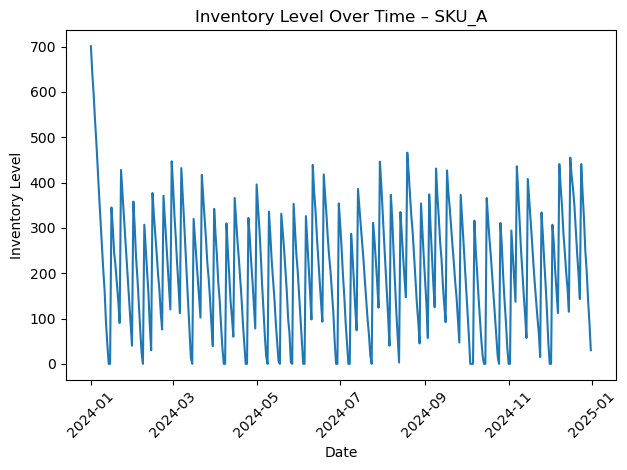

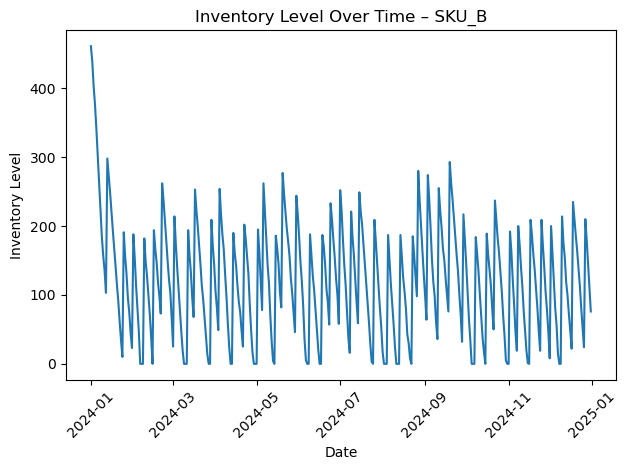

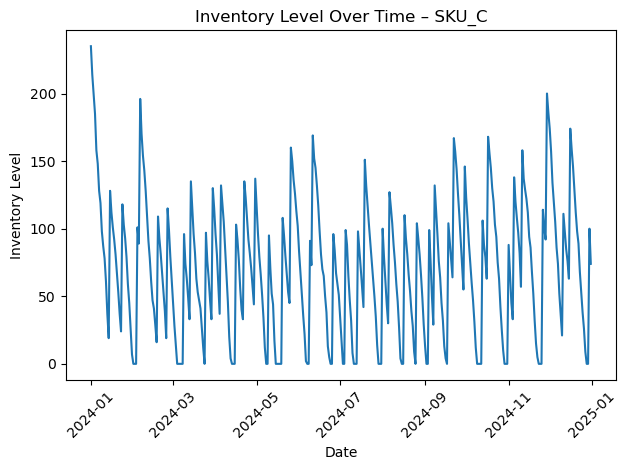

In [28]:
for sku in df["sku"].unique():
    sku_data = df[df["sku"] == sku]
    plt.figure()
    plt.plot(sku_data["date"], sku_data["inventory_level"])
    plt.title(f"Inventory Level Over Time – {sku}")
    plt.xlabel("Date")
    plt.ylabel("Inventory Level")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


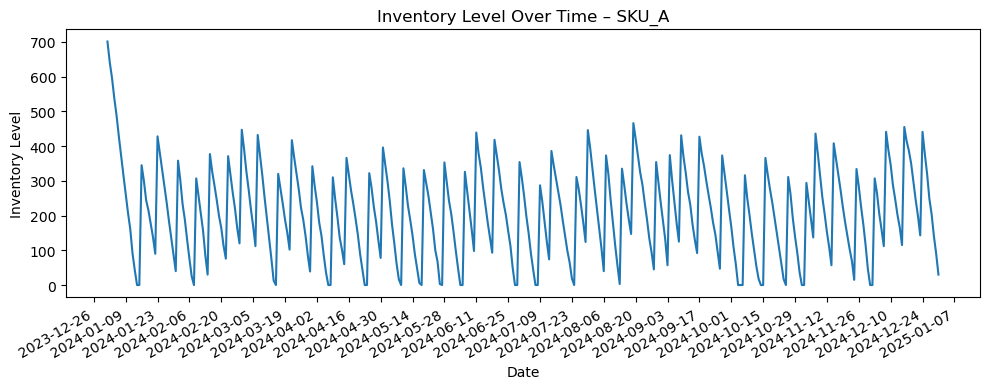

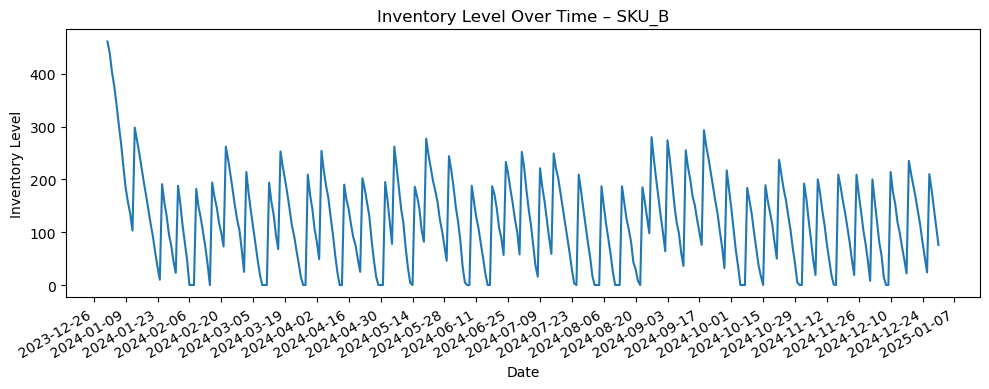

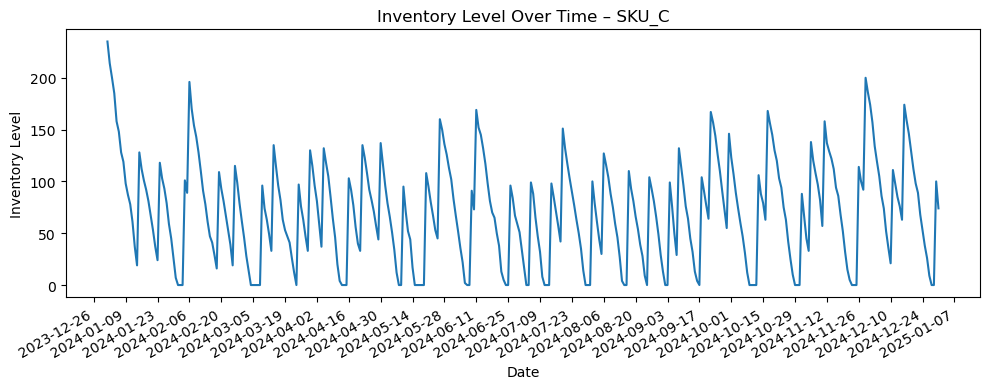

In [29]:
import matplotlib.dates as mdates

# Ensure date is datetime
df["date"] = pd.to_datetime(df["date"])

for sku in df["sku"].unique():
    sku_data = df[df["sku"] == sku]

    plt.figure(figsize=(10, 4))
    plt.plot(sku_data["date"], sku_data["inventory_level"])

    plt.title(f"Inventory Level Over Time – {sku}")
    plt.xlabel("Date")
    plt.ylabel("Inventory Level")

    # Format date axis
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()


# 9. Insights & Recommendations

### Key Insights
- Inventory levels for all SKUs decline rapidly, leading to frequent stockouts.
- High stockout rates indicate that current replenishment policies are insufficient.
- Demand variability differs slightly across SKUs, suggesting different safety stock needs.
- After inventory reaches zero, stock remains depleted for extended periods.

### Recommendations
- Increase safety stock levels for all SKUs, especially those with higher demand variability.
- Recalculate reorder points using historical demand and lead time data.
- Introduce continuous monitoring of stockout rate as a key warehouse KPI.
- Consider more frequent replenishment cycles to improve service levels.

Overall, this analysis demonstrates how exploratory data analysis and KPI monitoring can support proactive inventory management decisions.